## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
from tqdm.auto import tqdm 
from tqdm import tqdm_notebook

## Load Data

In [2]:
data_dir = 'data/'

# binary threshold (irrelevant <2; relevant >= 2)
thesis_qrels_threshold2_filename = 'thesis_dataset_binary_threshold2.tsv'

# binary theshold (irrelevant <3; relevant >= 3)
thesis_qrels_threshold3_filename = 'thesis_dataset_binary_threshold3.tsv'

# msmarco relevance file
og_qrels_filename = 'qrels.dev.small.tsv'

# BM25 top 100 ranking
bm25_top100_filename = 'run_development_top100.tsv'

# BERT top 100 ranking
bert_top100_filename = 'bert_thesis_dataset_top100.tsv'

In [3]:
bm25_df = pd.read_csv(data_dir + bm25_top100_filename,delimiter='\t',encoding='utf-8',header=None)
bm25_df.columns = ['query_id', 'passage_id', 'bm25_rank']

bert_df = pd.read_csv(data_dir + bert_top100_filename,delimiter='\t',encoding='utf-8',header=None)
bert_df.columns = ['query_id', 'passage_id', 'bm25_rank', 'query', 'passage', 'bert_score', 'bert_rank']

og_qrels_df = pd.read_csv(data_dir + og_qrels_filename,delimiter='\t',encoding='utf-8',header=None)
og_qrels_df.columns = ['query_id','label1','passage_id','label2']

new_qrels2_df = pd.read_csv(data_dir + thesis_qrels_threshold2_filename,delimiter='\t',encoding='utf-8',header=None)
new_qrels2_df.columns = ['query_id','label1','passage_id','label2']

new_qrels3_df = pd.read_csv(data_dir + thesis_qrels_threshold3_filename,delimiter='\t',encoding='utf-8',header=None)
new_qrels3_df.columns = ['query_id','label1','passage_id','label2']

models_dict = {"bm25": bm25_df, "bert": bert_df}
new_qrels_dict = {"threshold=2": new_qrels2_df, "threshold=3": new_qrels3_df}

## Helper Functions

In [4]:
def get_query_ids(dataframe):
    return list(np.unique(dataframe['query_id'].tolist()))

In [5]:
def get_top_n_ranking(dataframe,rank_column,n):
    top_n_ranking = dataframe[dataframe[rank_column] <= n].sort_values(by=[rank_column])
    return top_n_ranking

In [8]:
def get_ranks_relevant_passages(qrels_query_subset,top_n_ranking,model):
    ranks_relevant_items = sorted(qrels_query_subset.merge(top_n_ranking,how='left',on=['query_id','passage_id'])['%s_rank'%(model)].values.tolist())
    cleaned_rank_relevant_items = sorted([int(item) for item in ranks_relevant_items if ~np.isnan(item)])
    return cleaned_rank_relevant_items

In [7]:
def compute_precision(index,rank):
    precision = index/rank
    return precision

In [9]:
def compute_average_precision(sorted_ranks_relevant_items):
    average_precision = 0.0
    if not (len(sorted_ranks_relevant_items) == 0):
        summed_precision = 0.0
        for index,rank in enumerate(sorted_ranks_relevant_items):
            summed_precision += compute_precision(index+1,rank)
        average_precision = summed_precision/len(sorted_ranks_relevant_items)
    return average_precision

In [14]:
N= 10

## Compute Per Query MAP MS MARCO

In [15]:
bm25_map_values = []
bert_map_values = []

query_ids = get_query_ids(new_qrels2_df)
og_qrels_subset_df = og_qrels_df[og_qrels_df['query_id'].isin(query_ids)].copy()

for query_id in tqdm_notebook(query_ids):
    bm25_subset = bm25_df[bm25_df['query_id'] == query_id].copy()
    bert_subset = bert_df[bert_df['query_id'] == query_id].copy()
    qrels_query_subset = og_qrels_subset_df[og_qrels_subset_df['query_id'] == query_id]
    
    top_n_bm25_ranking = get_top_n_ranking(bm25_subset,'bm25_rank',N)
    top_n_bert_ranking = get_top_n_ranking(bert_subset,'bert_rank',N)
    
    bm25_relevant_items = get_ranks_relevant_passages(qrels_query_subset,top_n_bm25_ranking,"bm25")
    bert_relevant_items = get_ranks_relevant_passages(qrels_query_subset,top_n_bert_ranking,"bert")
    
    bm25_map_values.append(compute_average_precision(bm25_relevant_items))
    bert_map_values.append(compute_average_precision(bert_relevant_items))

c:\users\tomjg\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [16]:
diff_per_query_map = []
for index, bert_map in enumerate(bert_map_values):
    bm25_map = bm25_map_values[index]
    diff = bert_map - bm25_map
    diff_per_query_map.append(diff)
diff_per_query_map = sorted(diff_per_query_map,reverse=True)

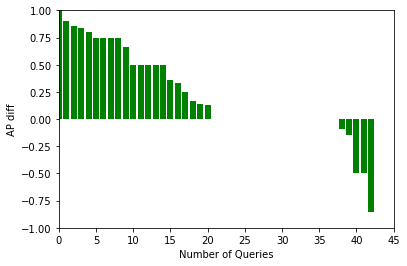

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.bar(range(len(diff_per_query_map)),diff_per_query_map, color='g')
plt.xlabel("Number of Queries")
plt.ylabel("AP diff")
plt.xlim([0,45])
plt.ylim([-1,1])
plt.savefig('per_query_ap_analysis_ms_marco.png', bbox_inches='tight')
plt.show()

## Compute Per Query MAP T=2

In [25]:
bm25_map_values = []
bert_map_values = []

query_ids = get_query_ids(new_qrels2_df)

for query_id in tqdm_notebook(query_ids):
    bm25_subset = bm25_df[bm25_df['query_id'] == query_id].copy()
    bert_subset = bert_df[bert_df['query_id'] == query_id].copy()
    qrels_query_subset = new_qrels2_df[new_qrels2_df['query_id'] == query_id]
    
    top_n_bm25_ranking = get_top_n_ranking(bm25_subset,'bm25_rank',N)
    top_n_bert_ranking = get_top_n_ranking(bert_subset,'bert_rank',N)
    
    bm25_relevant_items = get_ranks_relevant_passages(qrels_query_subset,top_n_bm25_ranking,"bm25")
    bert_relevant_items = get_ranks_relevant_passages(qrels_query_subset,top_n_bert_ranking,"bert")
    
    bm25_map_values.append(compute_average_precision(bm25_relevant_items))
    bert_map_values.append(compute_average_precision(bert_relevant_items))

c:\users\tomjg\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [26]:
diff_per_query_map = []
for index, bert_map in enumerate(bert_map_values):
    bm25_map = bm25_map_values[index]
    diff = bert_map - bm25_map
    diff_per_query_map.append(diff)
diff_per_query_map = sorted(diff_per_query_map,reverse=True)

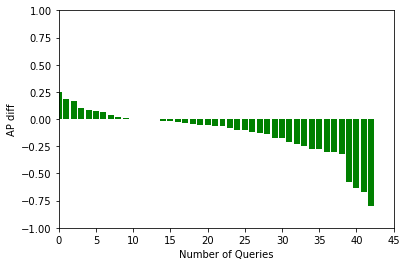

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.bar(range(len(diff_per_query_map)),diff_per_query_map, color='g')
plt.xlabel("Number of Queries")
plt.ylabel("AP diff")
plt.xlim([0,45])
plt.ylim([-1,1])
plt.savefig('per_query_ap_analysis_t2.png', bbox_inches='tight')
plt.show()

## Compute Per Query MAP T=3

In [21]:
bm25_map_values = []
bert_map_values = []

query_ids = get_query_ids(new_qrels3_df)

for query_id in tqdm_notebook(query_ids):
    bm25_subset = bm25_df[bm25_df['query_id'] == query_id].copy()
    bert_subset = bert_df[bert_df['query_id'] == query_id].copy()
    qrels_query_subset = new_qrels3_df[new_qrels3_df['query_id'] == query_id]
    
    top_n_bm25_ranking = get_top_n_ranking(bm25_subset,'bm25_rank',N)
    top_n_bert_ranking = get_top_n_ranking(bert_subset,'bert_rank',N)
    
    bm25_relevant_items = get_ranks_relevant_passages(qrels_query_subset,top_n_bm25_ranking,"bm25")
    bert_relevant_items = get_ranks_relevant_passages(qrels_query_subset,top_n_bert_ranking,"bert")
    
    bm25_map_values.append(compute_average_precision(bm25_relevant_items))
    bert_map_values.append(compute_average_precision(bert_relevant_items))

c:\users\tomjg\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [22]:
diff_per_query_map = []
for index, bert_map in enumerate(bert_map_values):
    bm25_map = bm25_map_values[index]
    diff = bert_map - bm25_map
    diff_per_query_map.append(diff)
diff_per_query_map = sorted(diff_per_query_map,reverse=True)

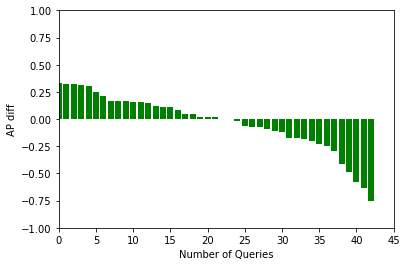

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.bar(range(len(diff_per_query_map)),diff_per_query_map, color='g')
plt.xlabel("Number of Queries")
plt.ylabel("AP diff")
plt.xlim([0,45])
plt.ylim([-1,1])
plt.savefig('per_query_ap_analysis_t3.png', bbox_inches='tight')
plt.show()